 # Natural Language Processing for Spam classification.

In [20]:
#Imports
import sys
import nltk
import sklearn
import pandas
import numpy
seed = 2020

### 2. Load the Dataset
Now that we have ensured that our libraries are installed correctly, let's load the data set as a Pandas DataFrame. Furthermore, let's extract some useful information such as the column information and class distributions.

The data set we will be using comes from the UCI Machine Learning Repository. It contains over 5000 SMS labeled messages that have been collected for mobile phone spam research. 

In [3]:
import pandas as pd
import numpy as np

# load the dataset of SMS messages. Change it to the right local path.
df = pd.read_table('smsspamcollection/SMSSPamCollection', header=None, encoding='utf-8')

In [4]:
# print useful information about the dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


ham     4825
spam     747
Name: 0, dtype: int64


Text(0.5, 1.0, 'Classes distribution')

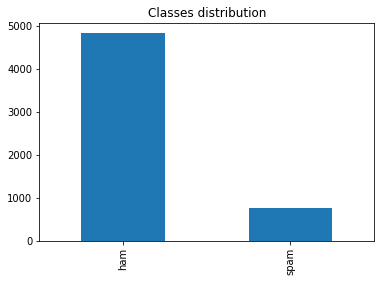

In [6]:
# check class distribution
classes = df[0]
print(classes.value_counts())
classes.value_counts().plot(kind='bar').set_title('Classes distribution')

### 2. Preprocess the Data
Preprocessing the data is an essential step in natural language process. In the following cells, we will convert our class labels to binary values using the LabelEncoder from sklearn, replace email addresses, URLs, phone numbers, and other symbols by using regular expressions, remove stop words, and extract word stems.

In [8]:
from sklearn.preprocessing import LabelEncoder

# convert class labels to binary values, 0 = ham and 1 = spam
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)
np.unique(Y)

array([0, 1])

In [9]:
# store the text message data
text_messages = df[1]
print(text_messages[:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: 1, dtype: object


In [12]:
# change words to lower case - Hello, HELLO, hello are all the same word
processed = text_messages.str.lower()
print(processed[0:10])

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
5    freemsg hey there darling it's been 3 week's n...
6    even my brother is not like to speak with me. ...
7    as per your request 'melle melle (oru minnamin...
8    winner!! as a valued network customer you have...
9    had your mobile 11 months or more? u r entitle...
Name: 1, dtype: object


### 3. Generating Features
Feature engineering is the process of using domain knowledge of the data to create features for machine learning algorithms. In this project, the words in each text message will be our features. For this purpose, it will be necessary to tokenize each word. We will use the 1500 most common words as features.

In [15]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# create bag-of-words
all_words = []

for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

[nltk_data] Downloading package punkt to /Users/youssef/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 9440
Most common words: [('.', 4738), ('i', 2929), ('to', 2252), ('you', 2236), (',', 1938), ('?', 1550), ('a', 1441), ('!', 1397), ('the', 1337), ('...', 1146), ('u', 1136), ('and', 978), ('&', 922), ('is', 905), ('in', 891)]


In [17]:
# use the 1500 most common words as features
word_features = list(all_words.keys())[:1500]

In [19]:
def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# Lets see an example!
features = find_features(processed[0])
for key, value in features.items():
    if value == True:
        print(key[0:10])

go
until
jurong
point
,
crazy
..
available
only
in
bugis
n
great
world
la
e
buffet
...
cine
there
got
amore
wat


In [31]:
type(processed), type(Y)

(pandas.core.series.Series, numpy.ndarray)

In [49]:
import random
# Now lets do it for all the messages
messages = list(zip(processed, Y))
print(type(messages))
print(messages[0])

# define a seed for reproducibility
seed = 1
np.random.seed = seed
random.shuffle(messages)
print(messages[0])

# call find_features function for each SMS message
featuresets = [(find_features(text), label) for (text, label) in messages]
print(type(featuresets[0]))

<class 'list'>
('go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...', 0)
("i would but i'm still cozy. and exhausted from last night.nobody went to school or work. everything is closed.", 0)
<class 'tuple'>


In [47]:
# we can split the featuresets into training and testing datasets using sklearn
from sklearn.model_selection import train_test_split

# split the data into training and testing datasets
training, testing = train_test_split(featuresets, test_size = 0.25, random_state=seed)
print(len(training))
print(len(testing))

4179
1393


### 4. Scikit-Learn Classifiers with NLTK
Now that we have our dataset, we can start building algorithms! Let's start with a simple linear support vector classifier, then expand to other algorithms. We'll need to import each algorithm we plan on using from sklearn. We also need to import some performance metrics, such as accuracy_score and classification_report.





In [48]:
# We can use sklearn algorithms in NLTK
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC

model = SklearnClassifier(SVC(kernel = 'linear'))

# train the model on the training data
model.train(training)

# and test on the testing dataset!
accuracy = nltk.classify.accuracy(model, testing)*100
print("SVC Accuracy: {}".format(accuracy))


SVC Accuracy: 97.84637473079684


### Can we do better ?
#### Let's use regular expressions to pre-process the data further.

In [61]:
# use regular expressions to replace email addresses, URLs, phone numbers, other numbers

# Replace email addresses with 'email'
processed = text_messages.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [62]:
# change words to lower case - Hello, HELLO, hello are all the same word
processed = processed.str.lower()
print(processed[0:10])


0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in numbr a wkly comp to win fa cup ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been numbr week...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile numbr months or more u r entit...
Name: 1, dtype: object


In [63]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# remove stop words from text messages
stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

# Remove word stems using a Porter stemmer
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))

# create bag-of-words
all_words = []

for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

# use the 1500 most common words as features
word_features = list(all_words.keys())[:1500]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youssef/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# use the 1500 most common words as features
word_features = list(all_words.keys())[:1500]

In [57]:
# The find_features function will determine which of the 1500 word features are contained in the review
def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# Lets see an example!
features = find_features(processed[0])
for key, value in features.items():
    if value == True:
        print(key)

go
jurong
point
crazi
avail
bugi
n
great
world
la
e
buffet
cine
got
amor
wat


In [58]:
#Now lets do it for all the messages
messages = list(zip(processed, Y))
print(type(messages))
print(messages[0])

# define a seed for reproducibility
seed = 1
np.random.seed = seed
random.shuffle(messages)
print(messages[0])

# call find_features function for each SMS message
featuresets = [(find_features(text), label) for (text, label) in messages]
print(type(featuresets[0]))

<class 'list'>
('go jurong point crazi avail bugi n great world la e buffet cine got amor wat', 0)
('hello orang numbr month free access game news sport plu numbr free text numbr photo messag repli ye term appli www orang co uk ow', 1)
<class 'tuple'>


In [59]:
# split the data into training and testing datasets
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

In [68]:
type(training), len(training)

(list, 4179)

#### Now let's look at how this processing impacted our previous result.

In [60]:
# Use the same model as before.
model = SklearnClassifier(SVC(kernel = 'linear'))

# train the model on the training data
model.train(training)

# and test on the testing dataset!
accuracy = nltk.classify.accuracy(model, testing)*100
print("SVC Accuracy: {}".format(accuracy))

SVC Accuracy: 98.1335247666906


#### We indeed improved our results with this thorrow pre-preprocessing.
### Now let's try a different feature extraction technique ?
#### TF-IDF

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer(max_features= 5000)
#Term Frequency, Inverse Document Frequency
tfidf = TfidfTransformer()

messages = bow.fit_transform(processed)
messages = tfidf.fit_transform(messages)
messages = messages.toarray()

In [91]:
#from sklearn.cross_validation import train_test_split
# split the data into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(messages, Y, test_size = 0.25, random_state=seed)
type(X_train), type(X_train[0]), len(X_train)

(numpy.ndarray, numpy.ndarray, 4179)

In [99]:
# We know use sklearn LinearSVC classifier with the TD-IDF features.
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

svc  = LinearSVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# and test on the testing dataset!
accuracy = accuracy_score(y_test, y_pred)*100
f1_score = f1_score(y_test, y_pred)*100
print("SVC Accuracy: {}".format(accuracy))
print("SVC F1_score: {}".format(f1_score))

SVC Accuracy: 98.99497487437185
SVC F1_score: 96.08938547486034


#### We indeed improved the results.

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB()
]

models = zip(names, classifiers)

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    print("{} Accuracy: {}".format(name, accuracy))
    print("{} F1_score: {}".format(name, f1))

K Nearest Neighbors Accuracy: 91.95979899497488
K Nearest Neighbors F1_score: 56.58914728682171
Decision Tree Accuracy: 97.77458722182341
Decision Tree F1_score: 91.55313351498637
Random Forest Accuracy: 98.63603732950466
Random Forest F1_score: 94.64788732394366
Logistic Regression Accuracy: 97.48743718592965
Logistic Regression F1_score: 89.79591836734696
SGD Classifier Accuracy: 99.13854989231874
SGD Classifier F1_score: 96.66666666666667
Naive Bayes Accuracy: 97.70279971284997
Naive Bayes F1_score: 90.58823529411765


#### SDG Classifier acheives better results out of all the models we tried.

In [112]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier


nltk_ensemble = VotingClassifier(estimators = [('K Nearest Neighbors', KNeighborsClassifier()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Logistic Regression', LogisticRegression()), ('SGD Classifier', SGDClassifier(max_iter=100)), ('Naive Bayes', MultinomialNB())], voting = 'hard', n_jobs = -1)

nltk_ensemble.fit(X_train, y_train)
y_pred = nltk_ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)*100
f1 = sklearn.metrics.f1_score(y_test, y_pred)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))
print("Voting Classifier: F1_score: {}".format(f1))



Voting Classifier: Accuracy: 98.06173725771716
Voting Classifier: F1_score: 92.12827988338192


#### No improvements from the Voting Classifier.